In [65]:
#Step 0. Load libreries
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    r2_score, ConfusionMatrixDisplay,
    classification_report
    )
from sklearn.utils import resample
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [66]:
#Step 1. Load Data
url ="https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv"
df_raw = pd.read_csv(url, sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [67]:
df_raw.sample(10, random_state=2025)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1462,6.8,0.640,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
1162,8.5,0.320,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,7
412,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3,5
527,7.0,0.380,0.49,2.5,0.097,33.0,85.0,0.99620,3.39,0.77,11.4,6
1176,6.5,0.880,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2,4
1139,8.2,0.510,0.24,2.0,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,6
1556,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,5
971,10.4,0.260,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.9,6
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,5
1128,10.0,0.430,0.33,2.7,0.095,28.0,89.0,0.99840,3.22,0.68,10.0,5


Nos estan pidiendo Accuracy, MatrixConfussion y ClasificationReport. Para utilizar estas métricas primero tenemos que hacer una transformación de los datos, donde si el valor $X$ de quality es < 7 se considera 0, y si es mayor o igual que 7 seria 1.

La idea de esto es hacer una casificacion binaria

In [68]:
#Step 2. Preprocessing
df_baking = df_raw.copy()

df_baking.columns = df_baking.columns.str.lower().str.replace(" ","_")
df_baking['quality_binary'] = [1 if x >= 7 else 0 for x in df_baking['quality']]
df_baking['quality_binary'] = df_baking['quality_binary'].astype("category")
df_baking = df_baking.drop(columns='quality')

df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed_acidity         1599 non-null   float64 
 1   volatile_acidity      1599 non-null   float64 
 2   citric_acid           1599 non-null   float64 
 3   residual_sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free_sulfur_dioxide   1599 non-null   float64 
 6   total_sulfur_dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   ph                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality_binary        1599 non-null   category
dtypes: category(1), float64(11)
memory usage: 139.2 KB


In [69]:
df.sample(10, random_state=2025)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_binary
1462,6.8,0.640,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,0
1162,8.5,0.320,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,1
412,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3,0
527,7.0,0.380,0.49,2.5,0.097,33.0,85.0,0.99620,3.39,0.77,11.4,0
1176,6.5,0.880,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2,0
1139,8.2,0.510,0.24,2.0,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,0
1556,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,0
971,10.4,0.260,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.9,0
88,9.3,0.390,0.44,2.1,0.107,34.0,125.0,0.99780,3.14,1.22,9.5,0
1128,10.0,0.430,0.33,2.7,0.095,28.0,89.0,0.99840,3.22,0.68,10.0,0


In [70]:
#Step 3: EDA
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2025, stratify=df['quality_binary'])
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=2025)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((1087, 12), (192, 12), (320, 12))

In [71]:
df_train.value_counts('quality_binary')

,count
quality_binary,
0,936
1,151


In [72]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1087.0,8.281325,1.689119,4.70000,7.10000,7.9000,9.100000,15.60000
volatile_acidity,1087.0,0.525662,0.176890,0.12000,0.39250,0.5100,0.630000,1.58000
citric_acid,1087.0,0.270552,0.193273,0.00000,0.10000,0.2500,0.420000,1.00000
residual_sugar,1087.0,2.505750,1.352313,0.90000,1.90000,2.2000,2.600000,15.50000
chlorides,1087.0,0.087743,0.046798,0.01200,0.07100,0.0800,0.090500,0.61000
free_sulfur_dioxide,1087.0,15.807728,10.327814,1.00000,7.00000,13.0000,21.000000,68.00000
total_sulfur_dioxide,1087.0,46.358786,33.180870,6.00000,22.00000,37.0000,63.000000,289.00000
density,1087.0,0.996714,0.001859,0.99007,0.99563,0.9967,0.997800,1.00315
ph,1087.0,3.312318,0.149876,2.74000,3.21000,3.3100,3.390000,4.01000
sulphates,1087.0,0.660276,0.171897,0.33000,0.55000,0.6200,0.730000,2.00000


,count,unique,top,freq
quality_binary,1087,2,0,936


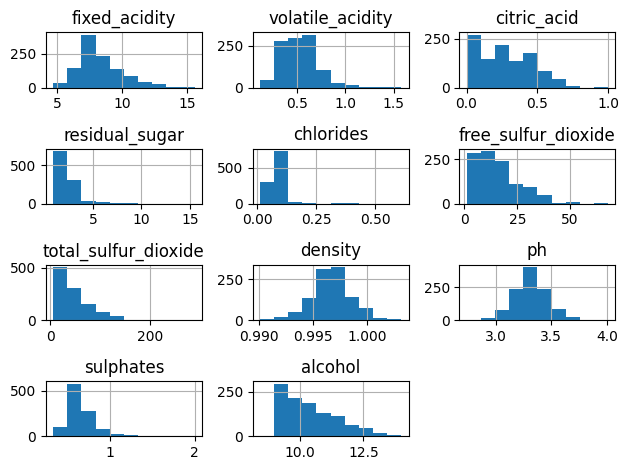

In [73]:
df_train.hist()
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


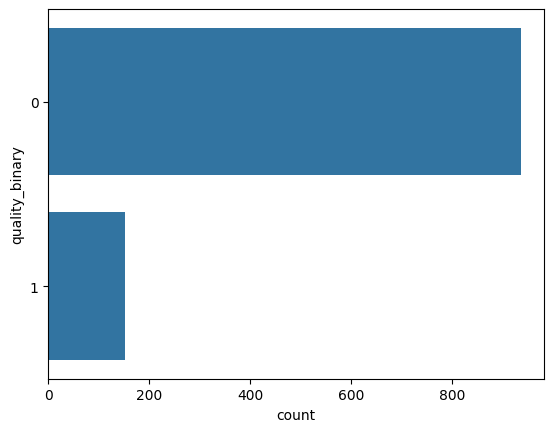

In [74]:
sns.countplot(df_train, y='quality_binary')
plt.show()

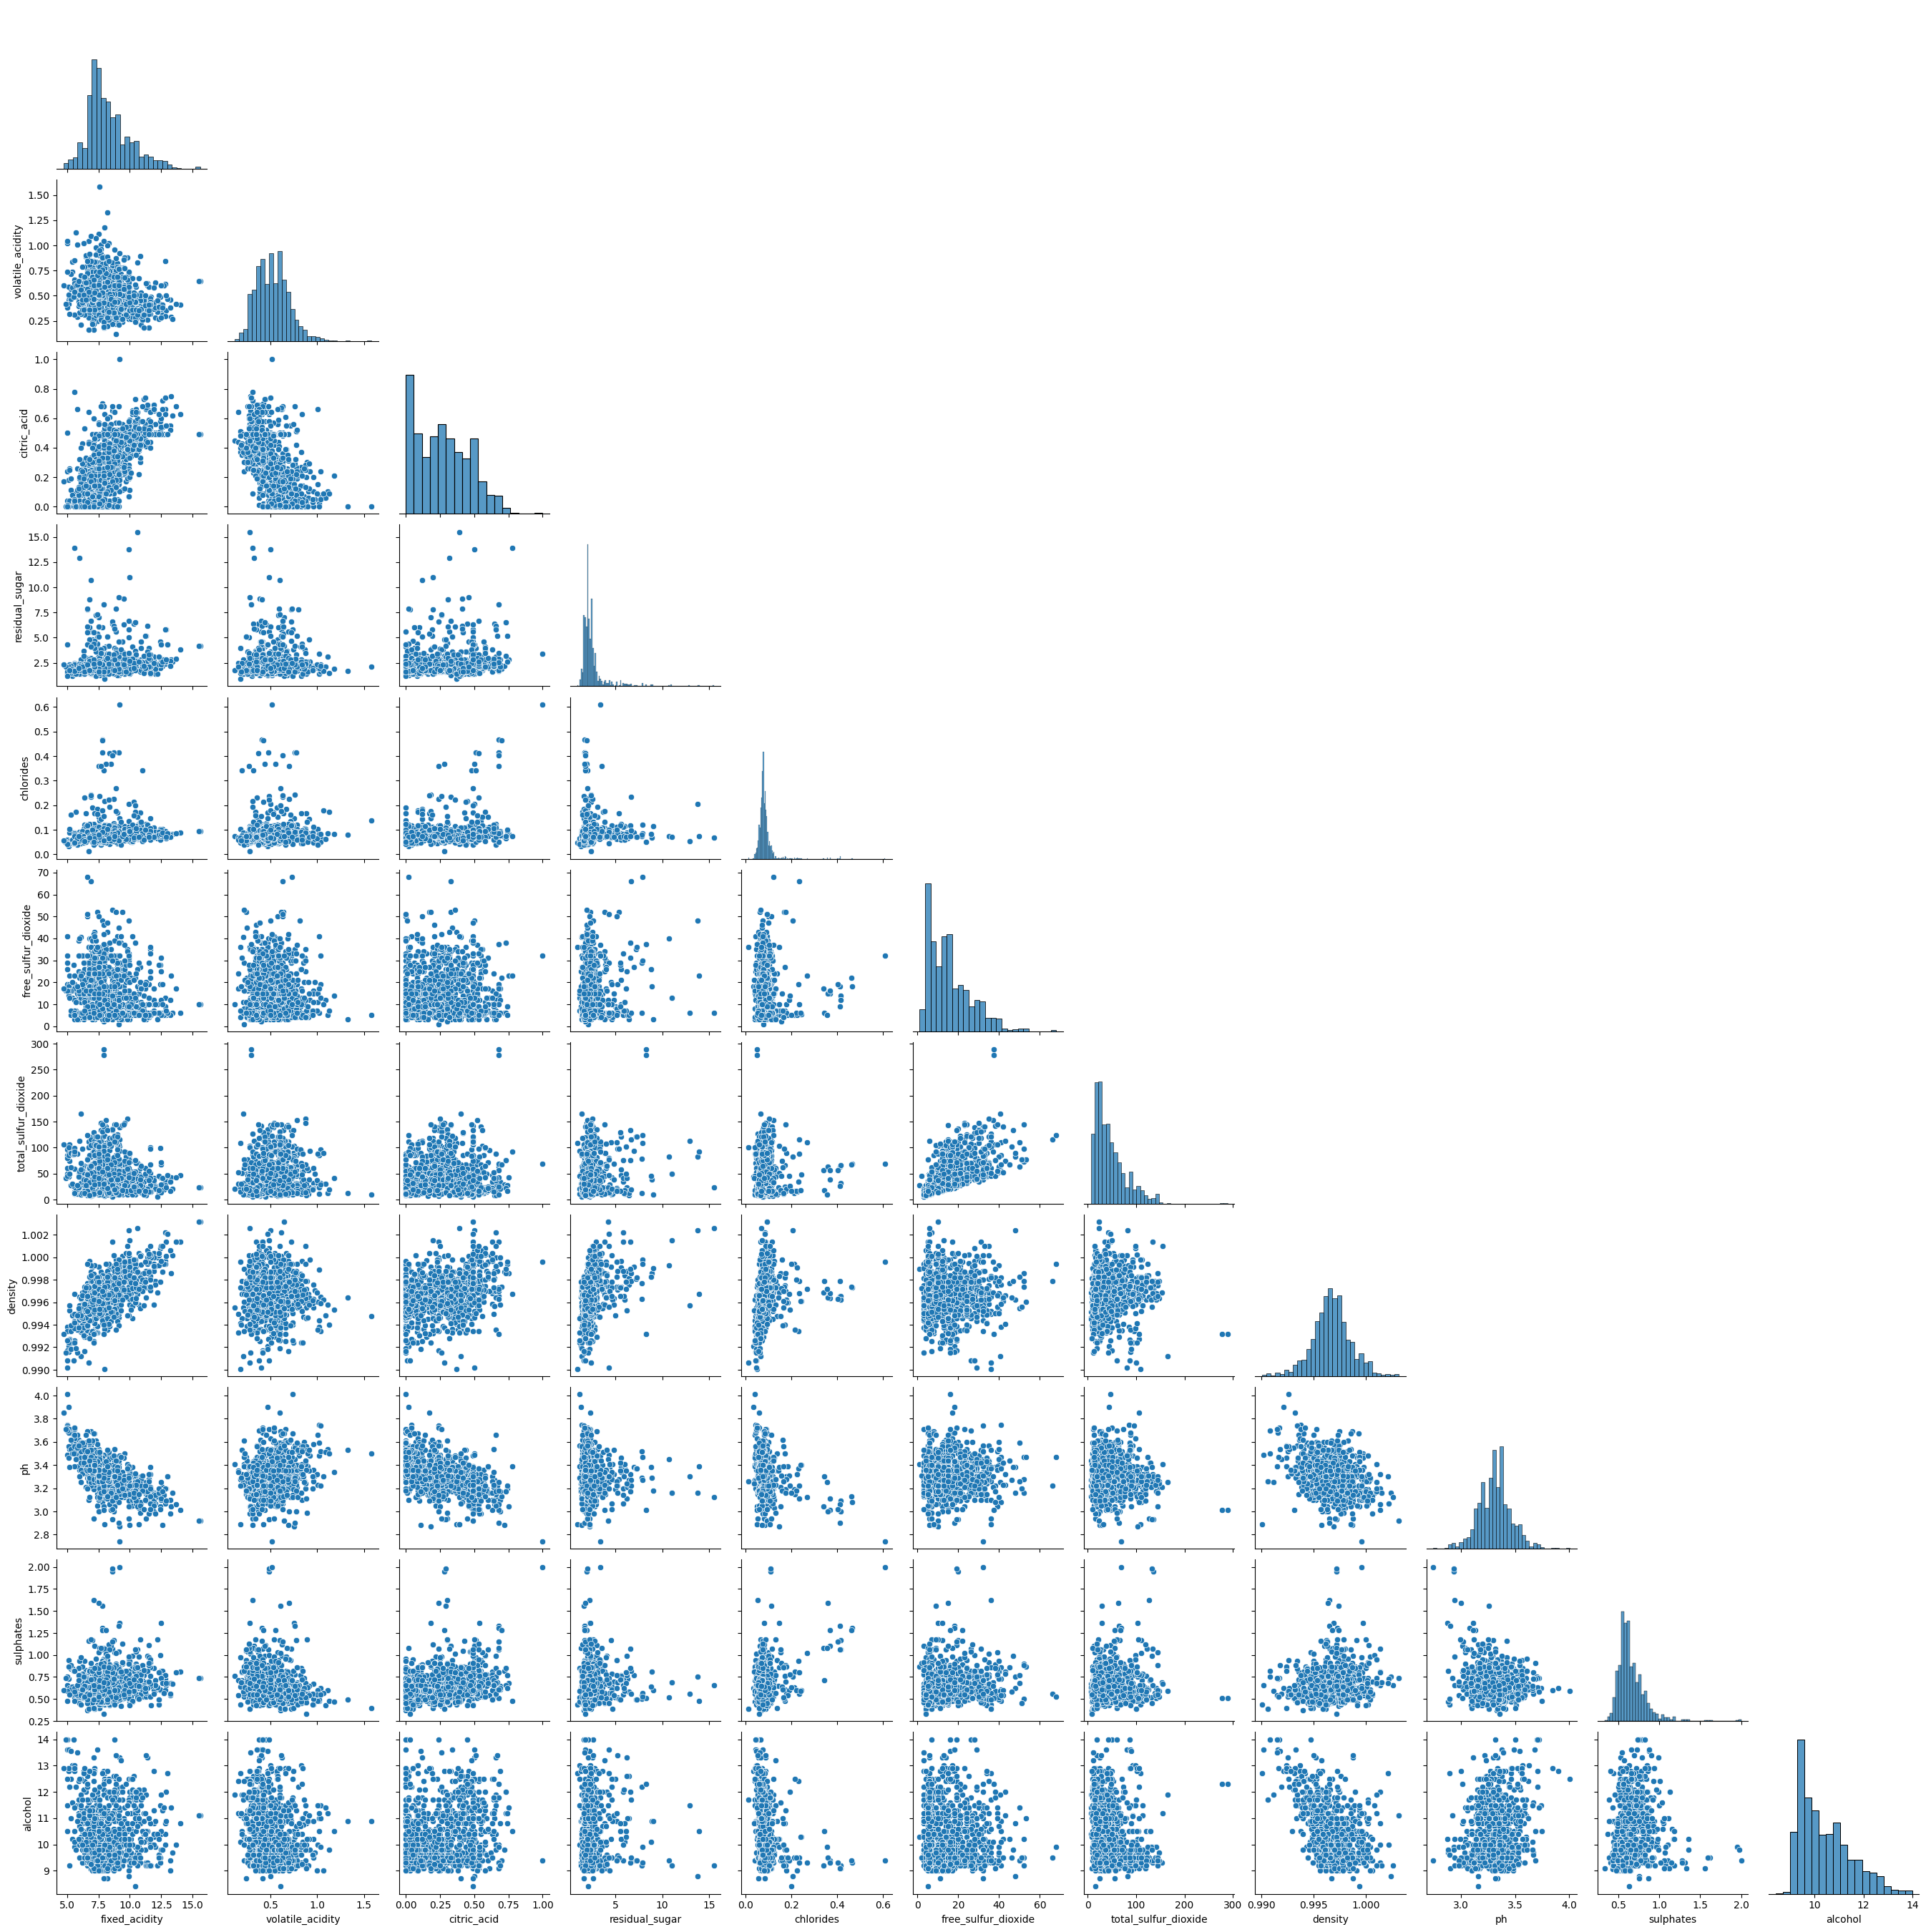

In [75]:
sns.pairplot(df_train, corner=True)
plt.show()

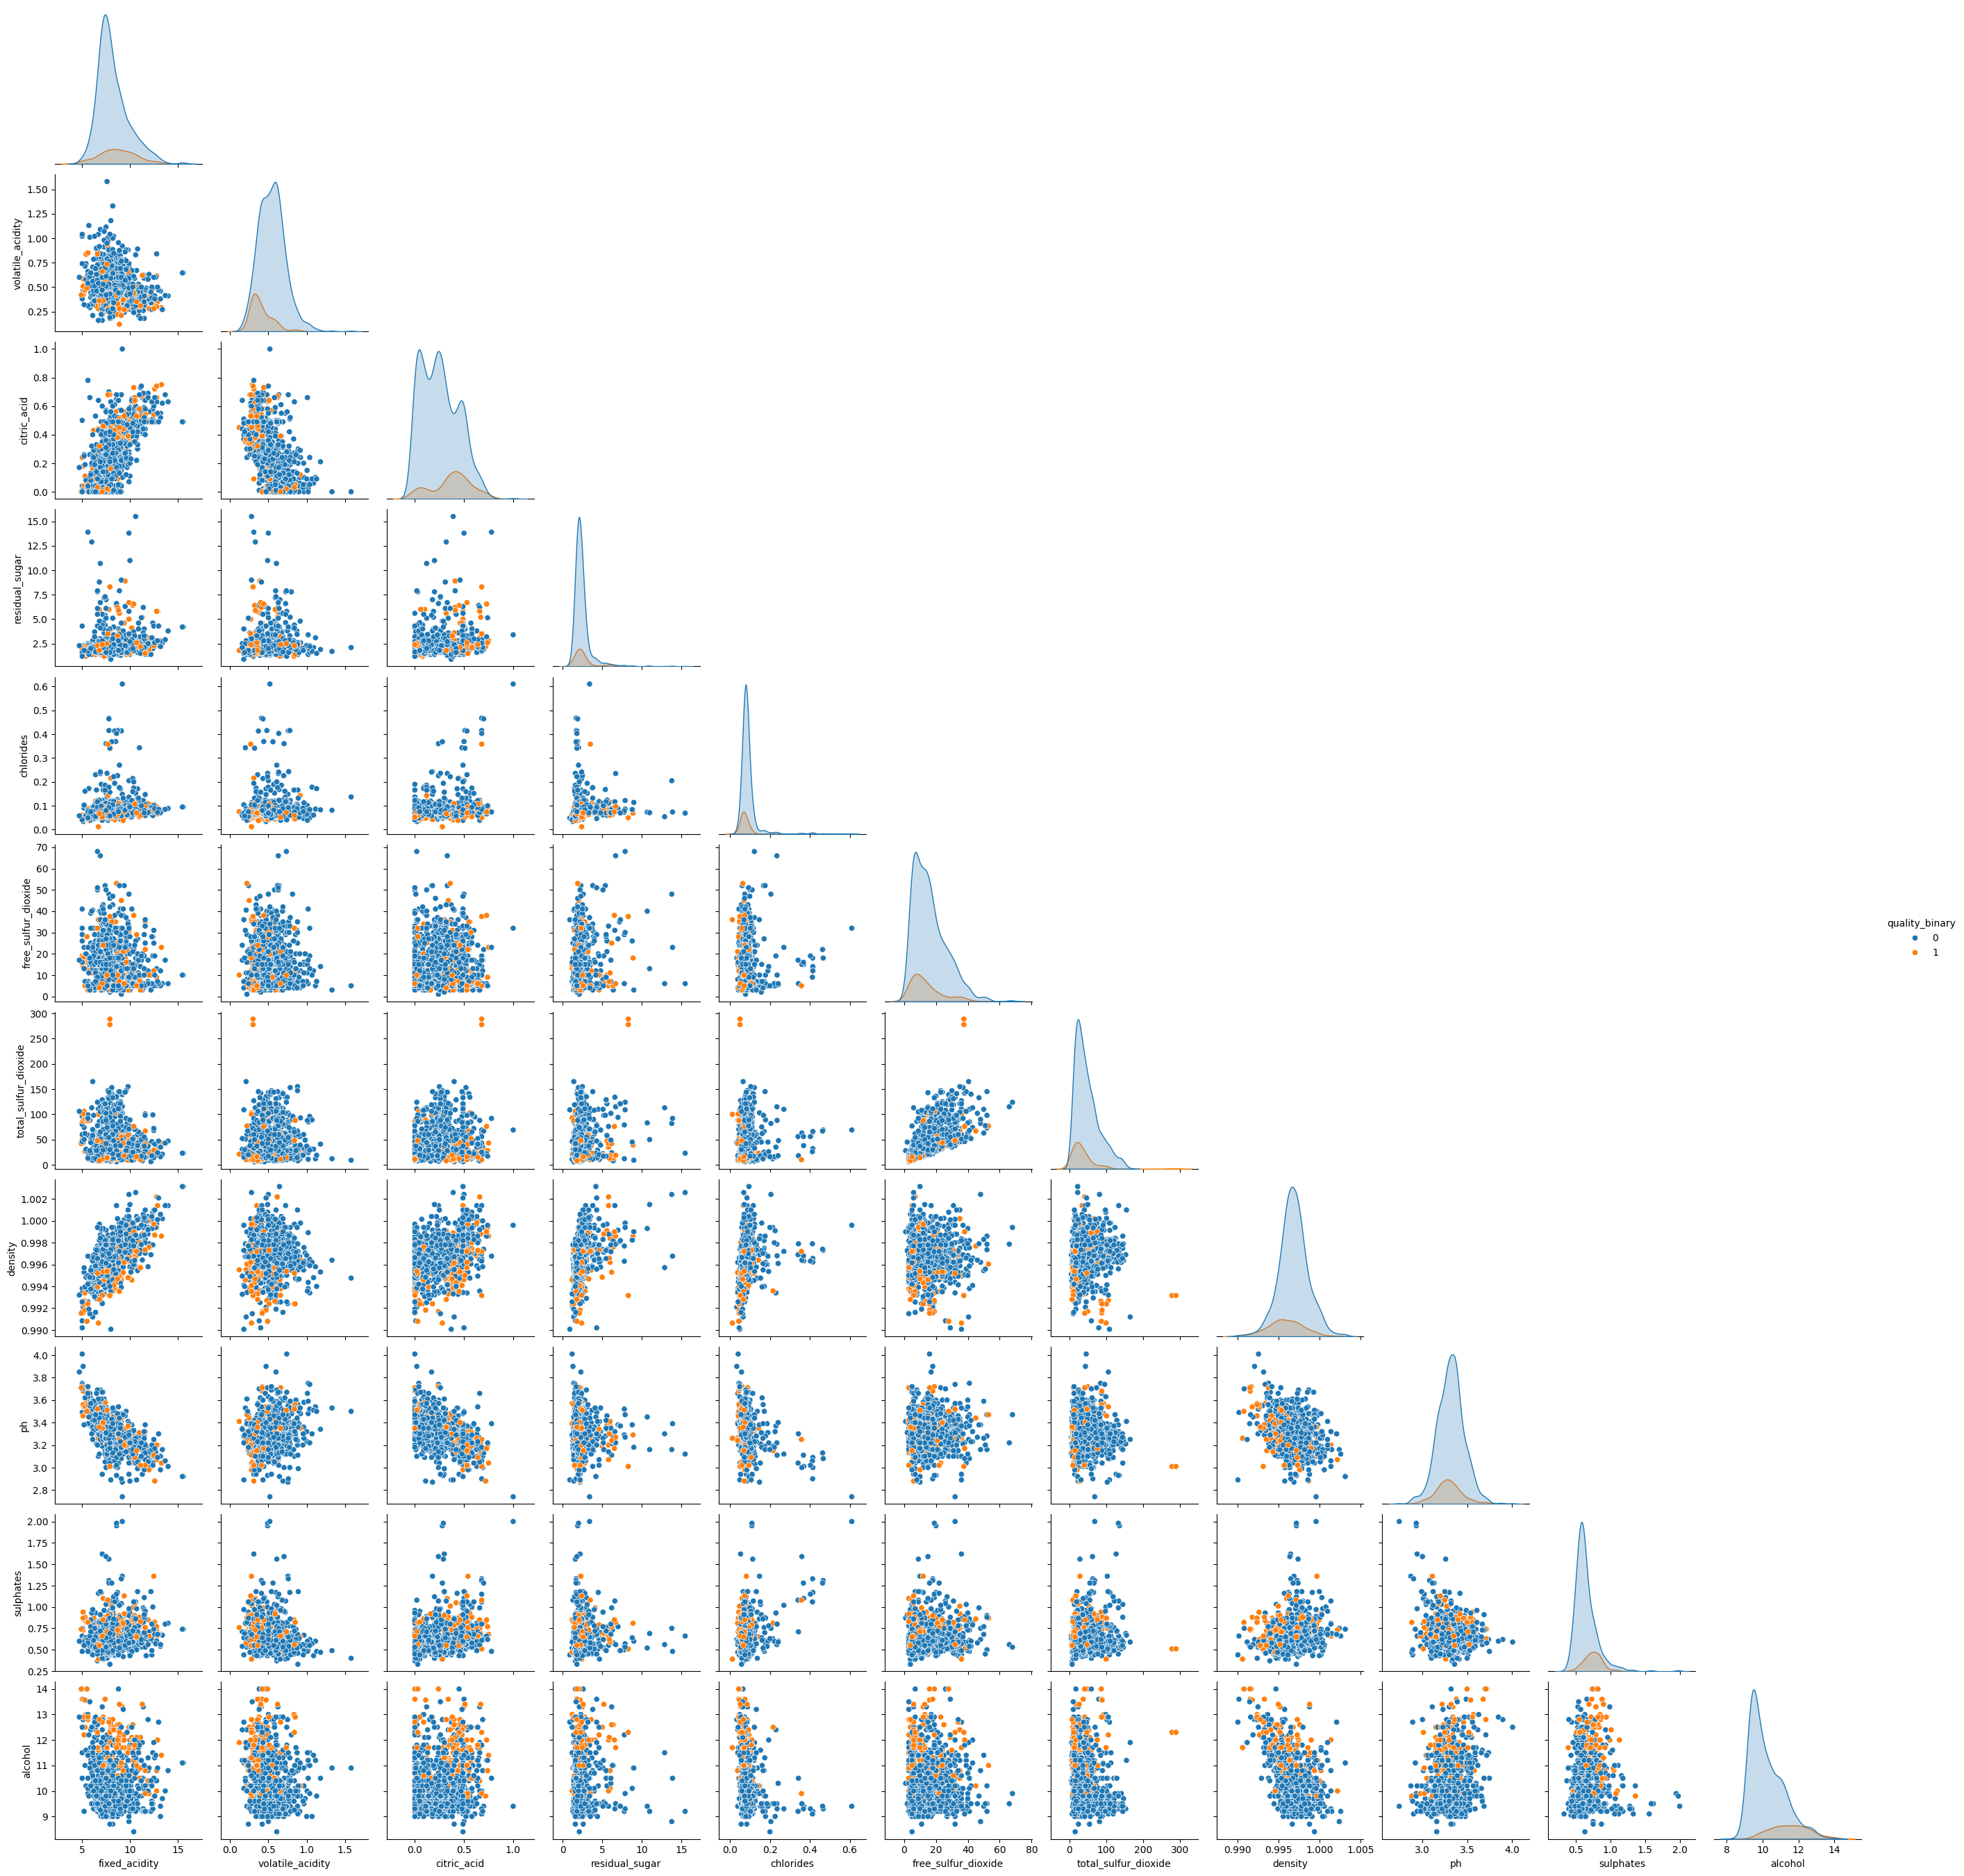

In [76]:
sns.pairplot(df_train, corner=True, hue='quality_binary')
plt.show()

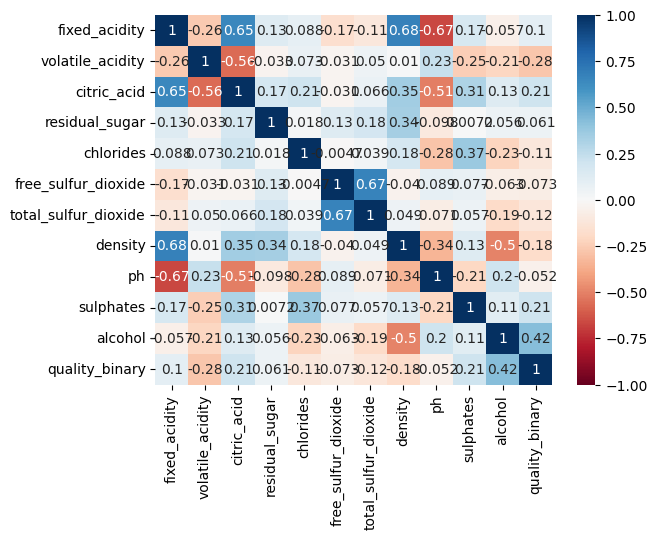

In [77]:
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True)
plt.show()

In [78]:
#Step 4. ML
X_train = df_train.drop(columns='quality_binary')
y_train = df_train['quality_binary']

X_val = df_val.drop(columns='quality_binary')
y_val = df_val['quality_binary']

X_test = df_test.drop(columns='quality_binary')
y_test = df_test['quality_binary']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1087, 11), (1087,), (192, 11), (192,), (320, 11), (320,))

In [79]:
#PipeLine para scalar los datos y aplicar modelo

reg_knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
reg_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [80]:
y_hat = reg_knn.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_hat)*100:.2f}%")
print(f"\nReporte de clasificación:\n {classification_report(y_val, y_hat,zero_division=0)}")

Accuracy: 91.15%

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       169
           1       0.71      0.43      0.54        23

    accuracy                           0.91       192
   macro avg       0.82      0.71      0.75       192
weighted avg       0.90      0.91      0.90       192



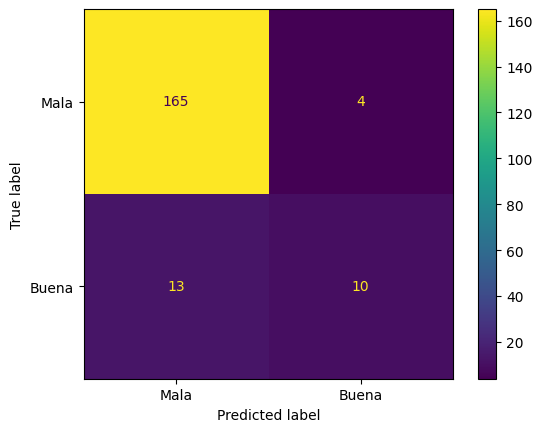

In [81]:
ConfusionMatrixDisplay.from_predictions(y_val, y_hat, display_labels=['Mala', 'Buena'])
plt.show()

In [82]:
reg_knn_cv = GridSearchCV(
    reg_knn,
    param_grid = {
        'knn__n_neighbors':[3,5,7,9,11,13,15,17,19,21],
    },
    cv=5,
)
reg_knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21]})

In [83]:
print(f"Mejor numero de vecinos {reg_knn_cv.best_params_}")

Mejor numero de vecinos {'knn__n_neighbors': 19}


In [84]:
y_hat = reg_knn_cv.best_estimator_.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_hat)*100:.2f}%")
print(f"\nReporte de clasificación:\n {classification_report(y_val, y_hat,zero_division=0)}")

Accuracy: 91.67%

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       169
           1       0.73      0.48      0.58        23

    accuracy                           0.92       192
   macro avg       0.83      0.73      0.77       192
weighted avg       0.91      0.92      0.91       192



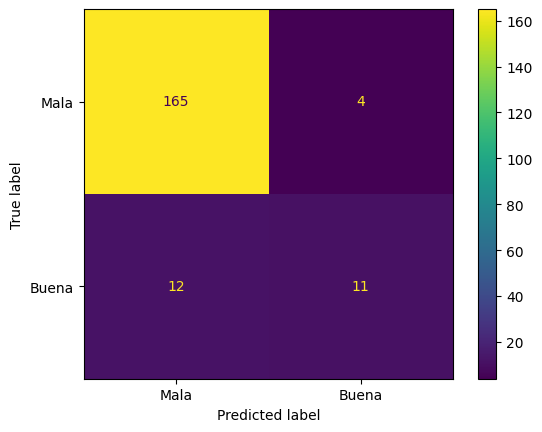

In [85]:
ConfusionMatrixDisplay.from_predictions(y_val, y_hat, display_labels=['Mala', 'Buena'])
plt.show()

### Mejor K para el conjunto de validación

In [100]:
k_values = range(1, 21, 2)
accuracy_scores = []

print("Iniciando optimización de k usando el conjunto de VALIDACIÓN")
for k in k_values:
    reg_knn = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

    reg_knn.fit(X_train, y_train)

    y_val_pred = reg_knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)

best_k_index = np.argmax(accuracy_scores)
best_k = k_values[best_k_index]
best_accuracy = accuracy_scores[best_k_index]

print(f"\nEl MEJOR valor de k (óptimo) es: {best_k} con un Accuracy de {best_accuracy:.4f} en el conjunto de VALIDACIÓN.")

Iniciando optimización de k usando el conjunto de VALIDACIÓN

El MEJOR valor de k (óptimo) es: 15 con un Accuracy de 0.9219 en el conjunto de VALIDACIÓN.


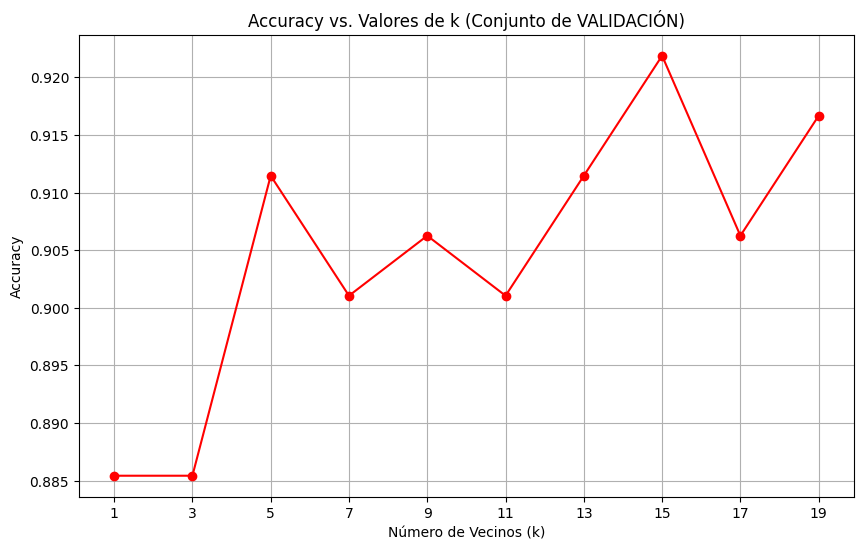

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Valores de k (Conjunto de VALIDACIÓN)')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Prueba final con el K del conjunto de validación, para mi conjunto de prueba

In [103]:
final_knn_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
final_knn_pipeline.fit(X_train, y_train)

y_test_final_pred = final_knn_pipeline.predict(X_test)
final_test_accuracy = accuracy_score(y_test, y_test_final_pred)

print("--- RENDIMIENTO FINAL ---\n")
print(f"Accuracy en el Conjunto de PRUEBA (con k={best_k}): {final_test_accuracy:.4f}")

--- RENDIMIENTO FINAL ---

Accuracy en el Conjunto de PRUEBA (con k=15): 0.8375
